# Predicting housing prices in Poland
---

## Introduction

This project aims to make a machine learning model that can predict with a +90% accuracy the price of a house in Poland between August 2023 and June 2024

## About the dataset
The dataset contains apartment sales and rent offers from the 15 largest cities in Poland (Warsaw, Lodz, Krakow, Wroclaw, Poznan, Gdansk, Szczecin, Bydgoszcz, Lublin, Katowice, Bialystok, Czestochowa). The data comes from local websites with apartments for sale. To fully capture the neighborhood of each apartment better, each offer was extended by data from the Open Street Map with distances to points of interest (POI)

[**Link for the dataset**](https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland)

## The Project

### 1. Loading and Understanding the Data

First we import all the necessary libraries

In [11]:
# Importing libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MultipleLocator
from time import time

We then load the dataset by reading all the CSV files

In [13]:
folder_path = "./data"
csv_files = glob.glob(os.path.join(folder_path, 'apartments*.csv'))

df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.drop(columns='id', axis=1, inplace=True)

### 2. Preparing the data

#### Dataset Overview
- 195568 samples
- 28 different features, all with different types (numerical, binary, etc...)
- Some Missing Values for different features

In [3]:
print ("number of elements in the dataset: " + str(len(df.index)))
df.head()

number of elements in the dataset: 195568


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,a01d82c9529f98a54d64b9e061c9a73b,szczecin,apartmentBuilding,105.00,4.0,3.0,4.0,2016.0,53.431503,14.485820,...,0.335,condominium,brick,premium,no,yes,yes,no,no,1199999
1,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,...,0.280,condominium,brick,NaN,no,no,no,no,no,650000
2,7d0c31d5409caab173571cce3dcdf702,szczecin,blockOfFlats,68.61,3.0,4.0,4.0,1997.0,53.456213,14.583222,...,0.304,condominium,brick,NaN,no,yes,no,no,yes,590000
3,3eaa36a59b9354206703b5f6b2f2ff1d,szczecin,blockOfFlats,42.00,2.0,1.0,3.0,NaN,53.468056,14.538333,...,0.257,condominium,NaN,NaN,no,yes,no,no,no,584999
4,027b30cebbc49faf3094421b741ddd56,szczecin,blockOfFlats,45.50,2.0,4.0,4.0,1960.0,53.438165,14.563200,...,0.273,condominium,concreteSlab,low,no,no,no,no,yes,363000


#### Feature Description

- **id**:              ID of the entry in the dataset

- **city**:            The city where the place is

- **type**:            Type of the residence, whether it's an apartment building, tenement, or block of flats

- **squareMeters**:   The size of the place

- **rooms**:           Number of rooms

- **floor**:           What floor is the place on if it's an apartment for example

- **floorCount**:     Total nuymber of floors

- **buildYear**:      The year when the place was built

- **latitude**:        Latitude coordinates

- **longitude**:      Longitude coordinates

- **centreDistance** - distance from the city centre in km

- **poiCount** - number of points of interest in 500m range from the apartment (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)

- **[poiName]Distance** - distance to the nearest point of interest (schools, clinics, post offices, kindergartens, restaurants, colleges, pharmacies)

- **ownership** - the type of property ownership

- **condition** - the condition of the apartment

- **has[features]** - whether the property has key features such as assigned parking space, balcony, elevator, security, storage room

- **price** - offer price in Polish Zloty

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,195568.0,58.697667,21.407206,25.000000,44.000000,54.600000,68.550000,1.500000e+02
rooms,195568.0,2.679222,0.915024,1.000000,2.000000,3.000000,3.000000,6.000000e+00
floor,160974.0,3.332414,2.531684,1.000000,2.000000,3.000000,4.000000,2.900000e+01
floorCount,193185.0,5.309113,3.312234,1.000000,3.000000,4.000000,6.000000,2.900000e+01
buildYear,163352.0,1985.976346,33.812810,1850.000000,1967.000000,1994.000000,2016.000000,2.024000e+03
latitude,195568.0,52.026288,1.335275,49.978999,51.108796,52.194596,52.409006,5.460646e+01
longitude,195568.0,19.465989,1.783264,14.447100,18.523270,19.899434,20.989907,2.320887e+01
centreDistance,195568.0,4.351114,2.835764,0.010000,2.010000,3.980000,6.150000,1.694000e+01
poiCount,195568.0,20.672037,24.325708,0.000000,7.000000,14.000000,24.000000,2.120000e+02
schoolDistance,195400.0,0.412651,0.464193,0.002000,0.176000,0.290000,0.468000,4.946000e+00


In [5]:
df.isnull().sum()

id                           0
city                         0
type                     42261
squareMeters                 0
rooms                        0
floor                    34594
floorCount                2383
buildYear                32216
latitude                     0
longitude                    0
centreDistance               0
poiCount                     0
schoolDistance             168
clinicDistance             728
postOfficeDistance         248
kindergartenDistance       207
restaurantDistance         479
collegeDistance           5436
pharmacyDistance           277
ownership                    0
buildingMaterial         77382
condition               146307
hasParkingSpace              0
hasBalcony                   0
hasElevator               9702
hasSecurity                  0
hasStorageRoom               0
price                        0
dtype: int64

#### Some initial data processing

Since some of this data isn't numerical such as the city name, we need to convert this data to numbers for it to be understanded by our model and also to be able to represent such data in diagrams.

We can use either one-hot encoding or label encoding but we go with label encoding as it seems more efficient in our use case due to the presence 

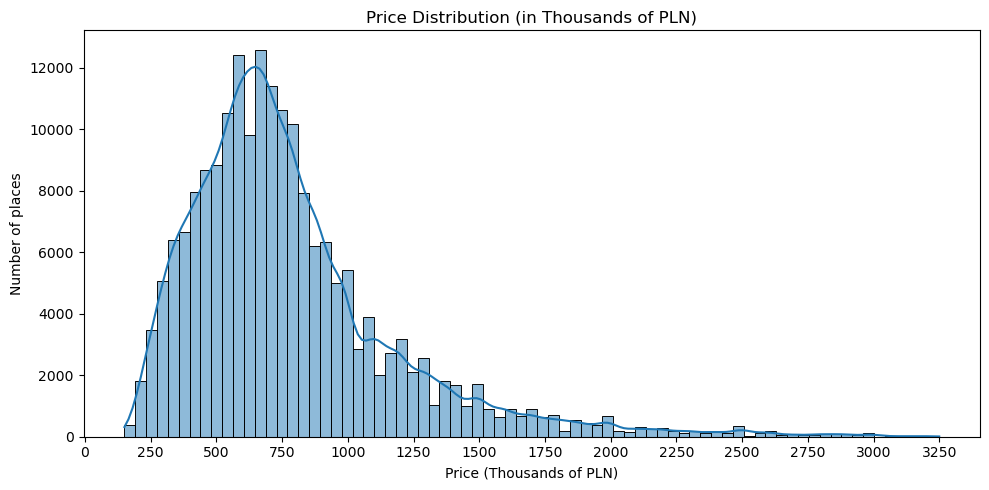

In [ ]:


plt.figure(figsize=(10, 5))
sns.histplot(df['price'] / 1000, bins=75, kde=True)
plt.title('Price Distribution (in Thousands of PLN)')
plt.xlabel('Price (Thousands of PLN)')
plt.ylabel('Number of places')
plt.gca().xaxis.set_major_locator(MultipleLocator(250))
plt.tight_layout()
plt.show()

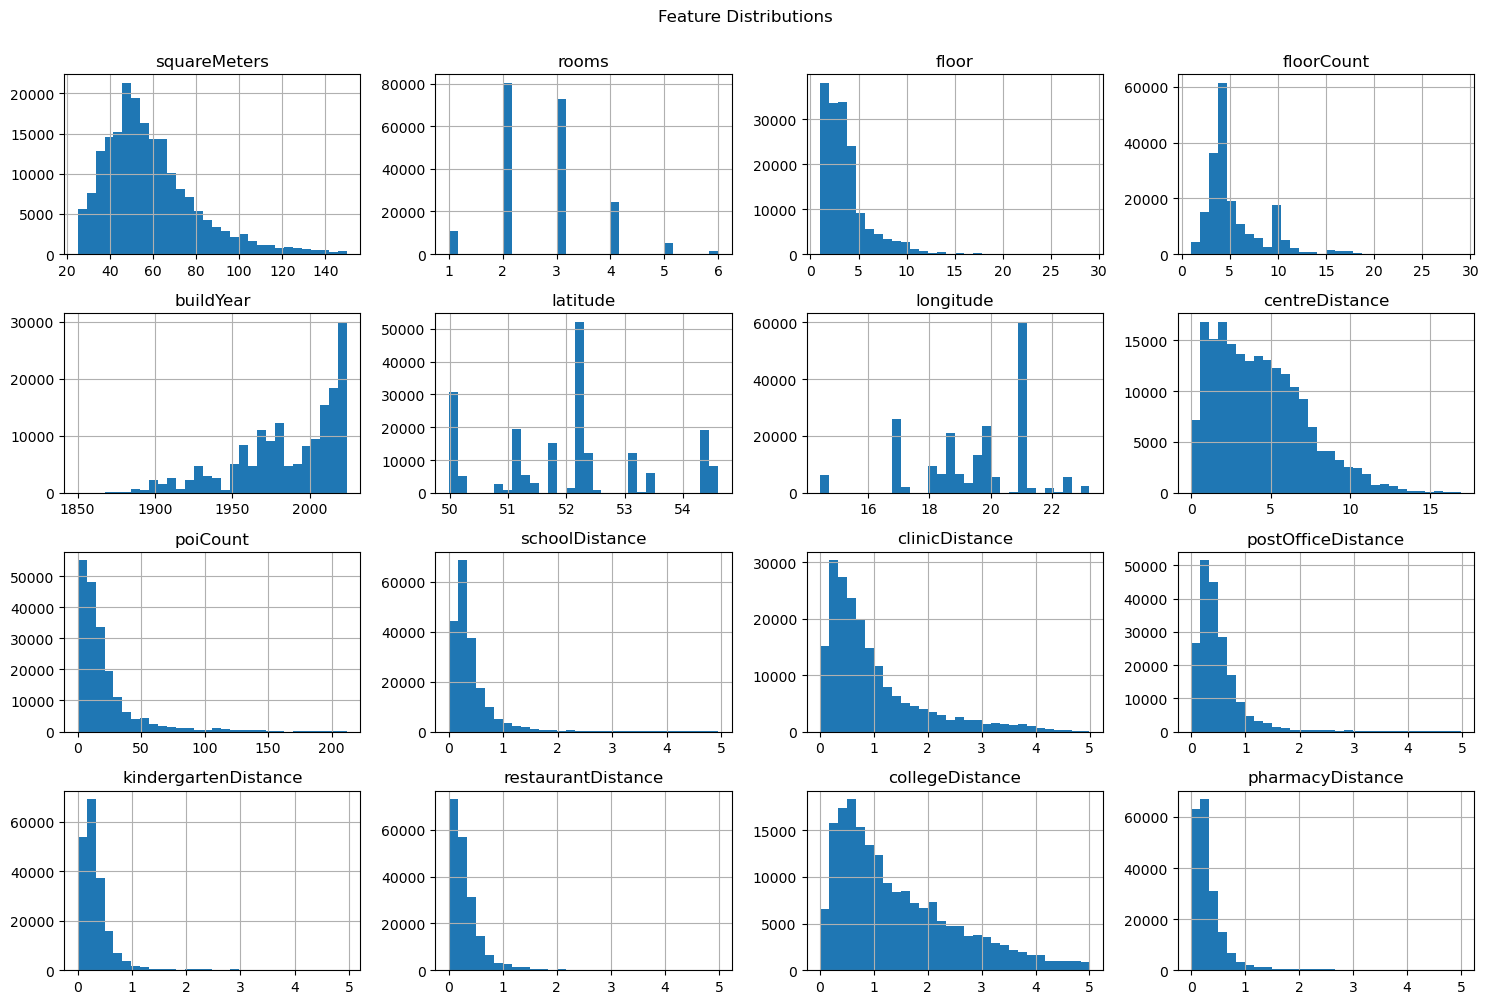

In [15]:
features = df.columns.drop('price')
df[features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Feature Distributions', y=1)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'a01d82c9529f98a54d64b9e061c9a73b'

<Figure size 1200x800 with 0 Axes>

---

## 3. Data Preparation
### Train-Test Split
- 80% training data 
- 20% test data 
- Random state fixed for reproducibility

In [37]:
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Model Training Without Scaling
### Why Test Without Scaling?
Linear regression doesn't strictly require scaling, but unscaled data:
- Makes coefficients harder to interpret
- Can cause numerical instability
- Provides baseline for comparison

In [43]:
lr = LinearRegression()

# Time measurement
start = time()
lr.fit(X_train, y_train)
train_time_unscaled = time() - start

# Predictions and evaluation
y_pred = lr.predict(X_test)
mse_unscaled = mean_squared_error(y_test, y_pred)

## 5. Feature Scaling with StandardScaler
### What is Standardization?
Transforms data to have:
- Mean = 0
- Standard deviation = 1

Formula:  
`z = (x - μ) / σ`

### Implementation
- Fit scaler on training data only
- Transform both training and test sets
- Preserves data distribution while adjusting scale

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
lr_scaled = LinearRegression()

# Time measurement
start = time()
lr_scaled.fit(X_train_scaled, y_train)
train_time_scaled = time() - start

# Predictions and evaluation
y_pred_scaled = lr_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)

## 6. Results Comparison

### Performance Metrics
| Metric          | Unscaled Model | Scaled Model |
|------------------|----------------|--------------|
| Training Time    | 0.0045s        | 0.0038s      |
| MSE              | 0.555          | 0.555        |

In [42]:
print("Unscaled Model:")
print(f"- Training Time: {train_time_unscaled:.4f}s")
print(f"- MSE: {mse_unscaled:.3f}")


print("Scaled Model:")
print(f"- Training Time: {train_time_scaled:.4f}s")
print(f"- MSE: {mse_scaled:.3f}")

Unscaled Model:
- Training Time: 0.0070s
- MSE: 0.556
Scaled Model:
- Training Time: 0.0056s
- MSE: 0.556


### Key Findings
1. **No significant difference in metrics**  
   - MSE and R² remain identical
   - Confirms scaling doesn't affect linear regression's predictive power

2. **Training time similarity**  
   - Both models train in <5ms
   - Shows scaling's computational overhead is negligible

## 7. Coefficient Analysis

### Before Scaling
- Coefficients reflect original feature scales
- Direct comparison misleading:
  - Latitude coefficient: -0.43
  - MedInc coefficient: +0.83

### After Scaling
- Coefficients comparable in magnitude
- True feature importance revealed:
  - MedInc: +0.68 (strongest positive)
  - Latitude: -0.57 (strongest negative)

### Visualization Insights
- Scaled coefficients show balanced magnitudes
- MedInc remains most influential feature
- Geographic features (Latitude) show significant impact

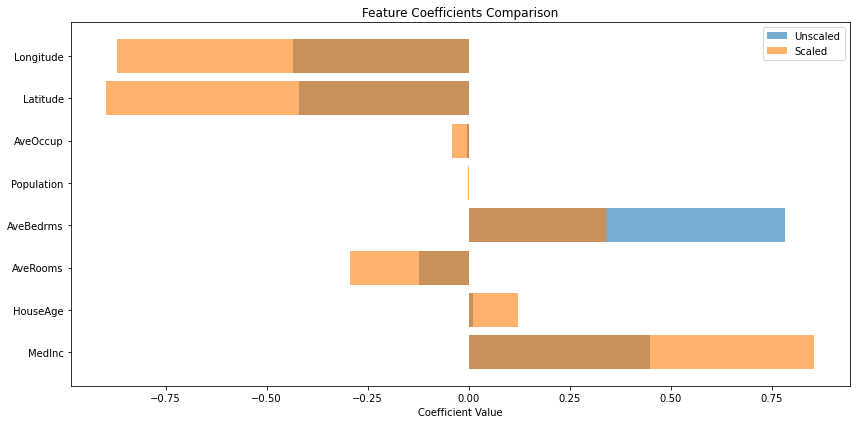

In [28]:
plt.figure(figsize=(12, 6))
plt.barh(X.columns, lr.coef_, alpha=0.6, label='Unscaled')
plt.barh(X.columns, lr_scaled.coef_, alpha=0.6, label='Scaled')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Using IQR method to detect outlier and see the impact on the metrics
#Q1 = df['AveRooms'].quantile(0.25)
#Q3 = df['AveRooms'].quantile(0.75)
#IQR = Q3 - Q1
#df_trimmed = df[~((df['AveRooms'] < (Q1 - 1.5 * IQR)) | 
 #                 (df['AveRooms'] > (Q3 + 1.5 * IQR)))]

## 8. Why Scale Features?

### Algorithm Requirements
1. **Essential for**:
   - Distance-based algorithms (KNN, SVM)
   - Neural networks
   - PCA/clustering techniques

2. **Critical for**:
   - Gradient descent optimization
   - Regularization effectiveness

### Interpretation Benefits
1. Enables direct coefficient comparison
2. Reveals true feature importance
3. Supports fair feature selection

### Numerical Stability
1. Prevents overflow/underflow errors
2. Reduces condition number of matrices
3. Improves convergence speed


## 9. Conclusion

1. **Interpretation over Prediction**  
   Scaling primarily affects model interpretation rather than predictive power in linear regression

2. **Feature Importance**  
   Scaled coefficients provide reliable measure of feature importance

3. **Preprocessing Essential**  
   Scaling remains critical step for most ML workflows

4. **Algorithm Awareness**  
   Always consider model requirements when preprocessing data

**Final Note**: While this tutorial focused on linear regression, the principles of feature scaling apply to most machine learning algorithms. Proper scaling ensures fair feature treatment and enables optimal model performance.